### IBM Employee Churn Prediction Model
##### ---- Sourav Sinha, PhD Economics Candidate, Yale University

_______________________________________________________________________________________________________________________________
#### # Project Goals: 
Predict employee churn (employee exits) using labelled data on employee and job characteristics

#### # Data Analyses Methods (in order of application):
1.   Data Wrangling and Feature Generation
    *   Check data types and convert into appropriate types.
    *   Check for missing values in columns and impute, if any.
    *   Rename levels of categorical type variables to enhance interpretability.
    *   Drop irrelevant and redundant columns from raw dataset.
2.   Exploratory Data Analyses
    *   Frequency Distribution of outcome variable.
    *   Tabulation and Visualization of summary statistics by one or more numeric and categorical features.
    *   Linear and Logistic Regression to interpret relation between outcome and feature variables.
    *   K-Means Clustering on features to detect possible clusters of employees.
3.   Predictions using following Classifier Models (with and without hyperparameter tuning):
    *   Logistic Regression
    *   Gradient Boosting
    *   Random Forest
    *   Neural Networks in Tensorflow
4.   Generate Prediction Metrics for each model and compare across models  


In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
import chardet
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import heapq
import re
import plotnine
import copy
import pydot
import graphviz
import datetime
from graphviz import Source
from scipy.stats import randint as sp_randint
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, logit 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from IPython.display import display
from pprint import pprint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorboard.plugins.hparams import api as hp

In [115]:
## Importing raw data into notebook

# Define paths to raw data, processed data, and graphs to be generated 
sourcepath = "D:\Work\Research\Dropbox\Machine Learning\Side Projects\Employee Churn IBM\employee_churn_prediction_ibm"
rawdatapath = os.path.join(sourcepath, 'data', 'raw')
finaldatapath = os.path.join(sourcepath, 'data', 'processed')
graphpath = os.path.join(sourcepath, 'reports', 'figures')
rawfilename = 'IBM HR Analytics.csv'
finalfilename = 'IBM_HR_Analytics_Processed.csv'

# Detecting encoding (if any) of the raw data file
rawdata = open(os.path.join(rawdatapath, rawfilename), 'rb').read()
result = chardet.detect(rawdata)
charenc = result['encoding']

# Load raw data into notebook using the encoding in 'charenc' 
IBMData = pd.read_csv(os.path.join(rawdatapath, rawfilename), encoding = charenc)

# Delete any redundant objects
del [rawdata, result, charenc, rawdatapath, rawfilename]

### (Step 1) Data Wrangling and Feature Correction

#### Methods Used:
* Column Data Types and Type Conversion
* Shape of Data Frame
* Checks for NULL and/or NaN values in columns and imputations, if required
* Drop Redundant and Irrelevant Columns 

In this section, we first explore the features in the raw datasets and their data types. Then, depending on how we interpret 
the feature we change the data types of the columns. We also note the number of observations in the data and the presence of 
NULL or NaN values in any column. If there are missing values, we impute missing values using one of the many imputation 
techniques. Further, we drop columns which have the same value for all observations and also columns which do not contain any 
relevant information. One such column is 'EmployeeNumber' which we can drop because it contains unique IDs for each employee 
and each employee features in our raw dataset only once. 

In [102]:
# (0) Visualizing dataframe head

IBMData.head(n=5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [116]:
# (1) Variable names and their data types
# print('Variable Names and Data Types:\n')
# print(IBMData.dtypes)

# (2) Number of observations
#print('-----------------------------------------------------------------------------------------------------------------------')
print('\nTotal number of observations in raw dataset: {}'.format(IBMData.shape[0]))

# (3) Check for presence of NULL/NA values in columns
print('-----------------------------------------------------------------------------------------------------------------------')
print('\nChecking for NaN values in dataframe columns....\n')
[print(x, IBMData[x].isna().sum()) for x in IBMData.columns if IBMData[x].isna().sum() > 0] # print colname and # of NaN values
if(~IBMData.isna().sum().sum()): print('Raw data has no NaN values.\n')     
print('Checking for Null values in dataframe columns....\n')
[print(IBMData[x].isnull().sum()) for x in IBMData.columns if IBMData[x].isnull().sum() > 0] # print colname and # of Null values
if(~IBMData.isnull().sum().sum()): print('Raw data has no Null values.\n')     
print('--- No imputations required.')

# (4) Drop columns which have no variation across rows
print('-----------------------------------------------------------------------------------------------------------------------')
print('\nDropping columns which have no variation across rows...\n')
for x in IBMData.columns:
    if(IBMData[x].nunique()==1): # check if the number of unique values == 1
        print('Column dropped: {}'.format(str(x)))
        IBMData.drop([x], axis = 1, inplace = True) # adjust the dataframe inplace by dropping the column 
        
# (5) Drop columns which have irrelevant information (like unique IDs)

# We drop the column 'EmployeeNumber' since it contains unique IDs for 
# each employee and we do not observe multiple instances of same employee.
print('-----------------------------------------------------------------------------------------------------------------------')
print('\nDropping Column: "EmployeeNumber" since it has unique ID for each observation...')
IBMData.drop(['EmployeeNumber'], axis = 1, inplace = True)


Total number of observations in raw dataset: 1470
-----------------------------------------------------------------------------------------------------------------------

Checking for NaN values in dataframe columns....

Raw data has no NaN values.

Checking for Null values in dataframe columns....

Raw data has no Null values.

--- No imputations required.
-----------------------------------------------------------------------------------------------------------------------

Dropping columns which have no variation across rows...

Column dropped: EmployeeCount
Column dropped: Over18
Column dropped: StandardHours
-----------------------------------------------------------------------------------------------------------------------

Dropping Column: "EmployeeNumber" since it has unique ID for each observation...


### (Step 2) Data Wrangling

* Convert column types into appropriate data types
* Rename levels of 'categorical' variables to improve interpretability

In [117]:
# (1) Convert all columns into one of three types: float, int, category 

# 'Float' type columns include all numeric columns (numvars), as well as some ordinal categorical variables (ordvars)
numvars = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 
          'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
           'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
ordvars = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 
          'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']

# 'Category' type columns include all categorical variables with no ordinal levels
catvars = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

# 'Integer' type columns include the outcome variable 'Attrition'
intvars = ['Attrition']

# Now convert the columns in numvars and ordvars lists to float
print('Converting some columns to "float"...')
#print(numvars + ordvars)
IBMData[numvars + ordvars] = IBMData[numvars + ordvars].apply(pd.to_numeric, downcast = 'float', axis = 1)

# Now convert the columns in catvars to 'category' type
print('-----------------------------------------------------------------------------------------------------------------------')
print('\nConverting some columns to "category"...')
#print(catvars)
IBMData[catvars] = IBMData[catvars].astype('category');

# Now convert the 'Attrition' column to 'integer' type
print('-----------------------------------------------------------------------------------------------------------------------')
print('\nConverting "Attrition" column to'' "integer"...')
exit_map = {'Yes':1, 'No':0} # Use a dictionary since this will be used later
IBMData['Attrition'] = IBMData['Attrition'].map(exit_map);


# (2) Rename levels of some categorical variables:
print('-----------------------------------------------------------------------------------------------------------------------')
print('\nRenaming some levels of some of the categorical variables...')
IBMData['BusinessTravel'].cat.rename_categories({
    'Travel_Rarely':'Rare', 'Travel_Frequently':'Frequent', 'Non-Travel':'No'}, inplace = True)
IBMData['Department'].cat.rename_categories({
    'Research & Development':'R&D','Sales':'Sales','Human Resources':'HR'}, inplace = True)
IBMData['EducationField'].cat.rename_categories({
    'Life Sciences':'LifeSc','Technical Degree':'Technical','Human Resources':'HR'}, inplace = True)
IBMData['JobRole'].cat.rename_categories({
    'Sales Executive':'SalexExec','Research Scientist':'Scientist','Laboratory Technician':'LabTech',
    'Manufacturing Director':'DirManufac','Healthcare Representative':'HealthRep','Sales Representative':'SalesRep',
    'Research Director':'DirResearch','Human Resources':'HR'}, inplace = True)

# (3) Final list of data types and column names
print('-----------------------------------------------------------------------------------------------------------------------')
maxlength = max(len(numvars + ordvars), len(catvars), 1)
typeframe = pd.DataFrame({'Float':numvars+ordvars, 
                          'Category':catvars+['']*(maxlength - len(catvars)),
                          'Integer':['Attrition']+['']*(maxlength - 1)})
print('\nData Types of Feature and Outcome Columns: \n')
print(typeframe)

# Deleting redundant data objects
del [typeframe, maxlength]

Converting some columns to "float"...
-----------------------------------------------------------------------------------------------------------------------

Converting some columns to "category"...
-----------------------------------------------------------------------------------------------------------------------

Converting "Attrition" column to "integer"...
-----------------------------------------------------------------------------------------------------------------------

Renaming some levels of some of the categorical variables...
-----------------------------------------------------------------------------------------------------------------------

Data Types of Feature and Outcome Columns: 

                       Float        Category    Integer
0                        Age  BusinessTravel  Attrition
1                  DailyRate      Department           
2           DistanceFromHome  EducationField           
3                 HourlyRate          Gender           
4    

### (Step 3) Processed Data Exploration

#### (Step 3.a) Exploring Outcome Variable ('Attrition')

* Proportion of workers leaving


#### (Step 3.b) Exploring Feature Variables

* Summary statistics of numeric variables (Table and Visualizations)
* Univariate Frequency Distributions of categorical variables (Table and Visualizations)
* Pairwise scatter plots of numeric variables
* Pairwise scatter plots of numeric variables (with categorical types)
* Summary statistics of numeric variables grouped by categorical types


#### (Step 3.c) Exploring Relationship between Outcome and Feature Variables

#### (Step 3.a) Proportion of employees who leave

Percentage of employees who leave: 16.122%



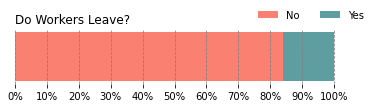

In [118]:
## (A) Exploring Outcome Variable: Attrition

print('Percentage of employees who leave: {:2.3%}\n'.format(IBMData['Attrition'].sum()/len(IBMData)))

# Show graphically the fraction of workers leaving
df_grouped = IBMData['Attrition'].value_counts()/len(IBMData) 
fracLeave = pd.DataFrame({df_grouped.index[0]:[df_grouped[0]], 
                          df_grouped.index[1]:[df_grouped[1]]}) # Create a dataframe with proportion of exits and retains
fracLeave.columns = fracLeave.columns.map(dict(map(reversed, exit_map.items()))) # Change the column names using the map defined 
fields = fracLeave.columns.to_list() # Get a list of the column names
colors = ['salmon', 'cadetblue']
left = len(fracLeave)*[0]

fig, ax = plt.subplots(figsize = (6,1))
for idx, name in enumerate(fields):
    plt.barh(fracLeave.index, fracLeave[name], left = left, color = colors[idx])
    left = left + fracLeave[name]
plt.title('Do Workers Leave?', loc = 'left')
plt.legend(fracLeave.columns.to_list(), ncol = 2, frameon = False, bbox_to_anchor = ([0.7, 1.0, 0., 0.]))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
xticks = np.arange(0,1.1,0.1)
xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
plt.xticks(xticks, xlabels)
ax.get_yaxis().set_ticks([])
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

# Delete redundant data objects
del [df_grouped, fracLeave, fields, colors, left, idx, name, fig, ax]

The plot above shows that over 80% of employees do not leave the firm. Only about 16% of employee exit. 

#### (Step 3.b) Summary Statistics of Numeric and Categorical Feature Variables

In [119]:
# (1) Summary Statistics of Numeric Variables

print('Descriptive Summary Statistics of all Numeric Variables:\n')
floatvar_stats = IBMData[numvars + ordvars].describe().transpose()
floatvar_stats

Descriptive Summary Statistics of all Numeric Variables:



,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923809,9.135373,18.0,30.0,36.0,43.00,60.0
DailyRate,1470.0,802.485718,403.509094,102.0,465.0,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106865,1.0,2.0,7.0,14.00,29.0
HourlyRate,1470.0,65.891159,20.329428,30.0,48.0,66.0,83.75,100.0
MonthlyIncome,1470.0,6502.931152,4707.956543,1009.0,2911.0,4919.0,8379.00,19999.0
MonthlyRate,1470.0,14313.103516,7117.786133,2094.0,8047.0,14235.5,20461.50,26999.0
NumCompaniesWorked,1470.0,2.693197,2.498009,0.0,1.0,2.0,4.00,9.0
PercentSalaryHike,1470.0,15.209524,3.659938,11.0,12.0,14.0,18.00,25.0
TotalWorkingYears,1470.0,11.279592,7.780782,0.0,6.0,10.0,15.00,40.0
TrainingTimesLastYear,1470.0,2.799320,1.289271,0.0,2.0,3.0,3.00,6.0


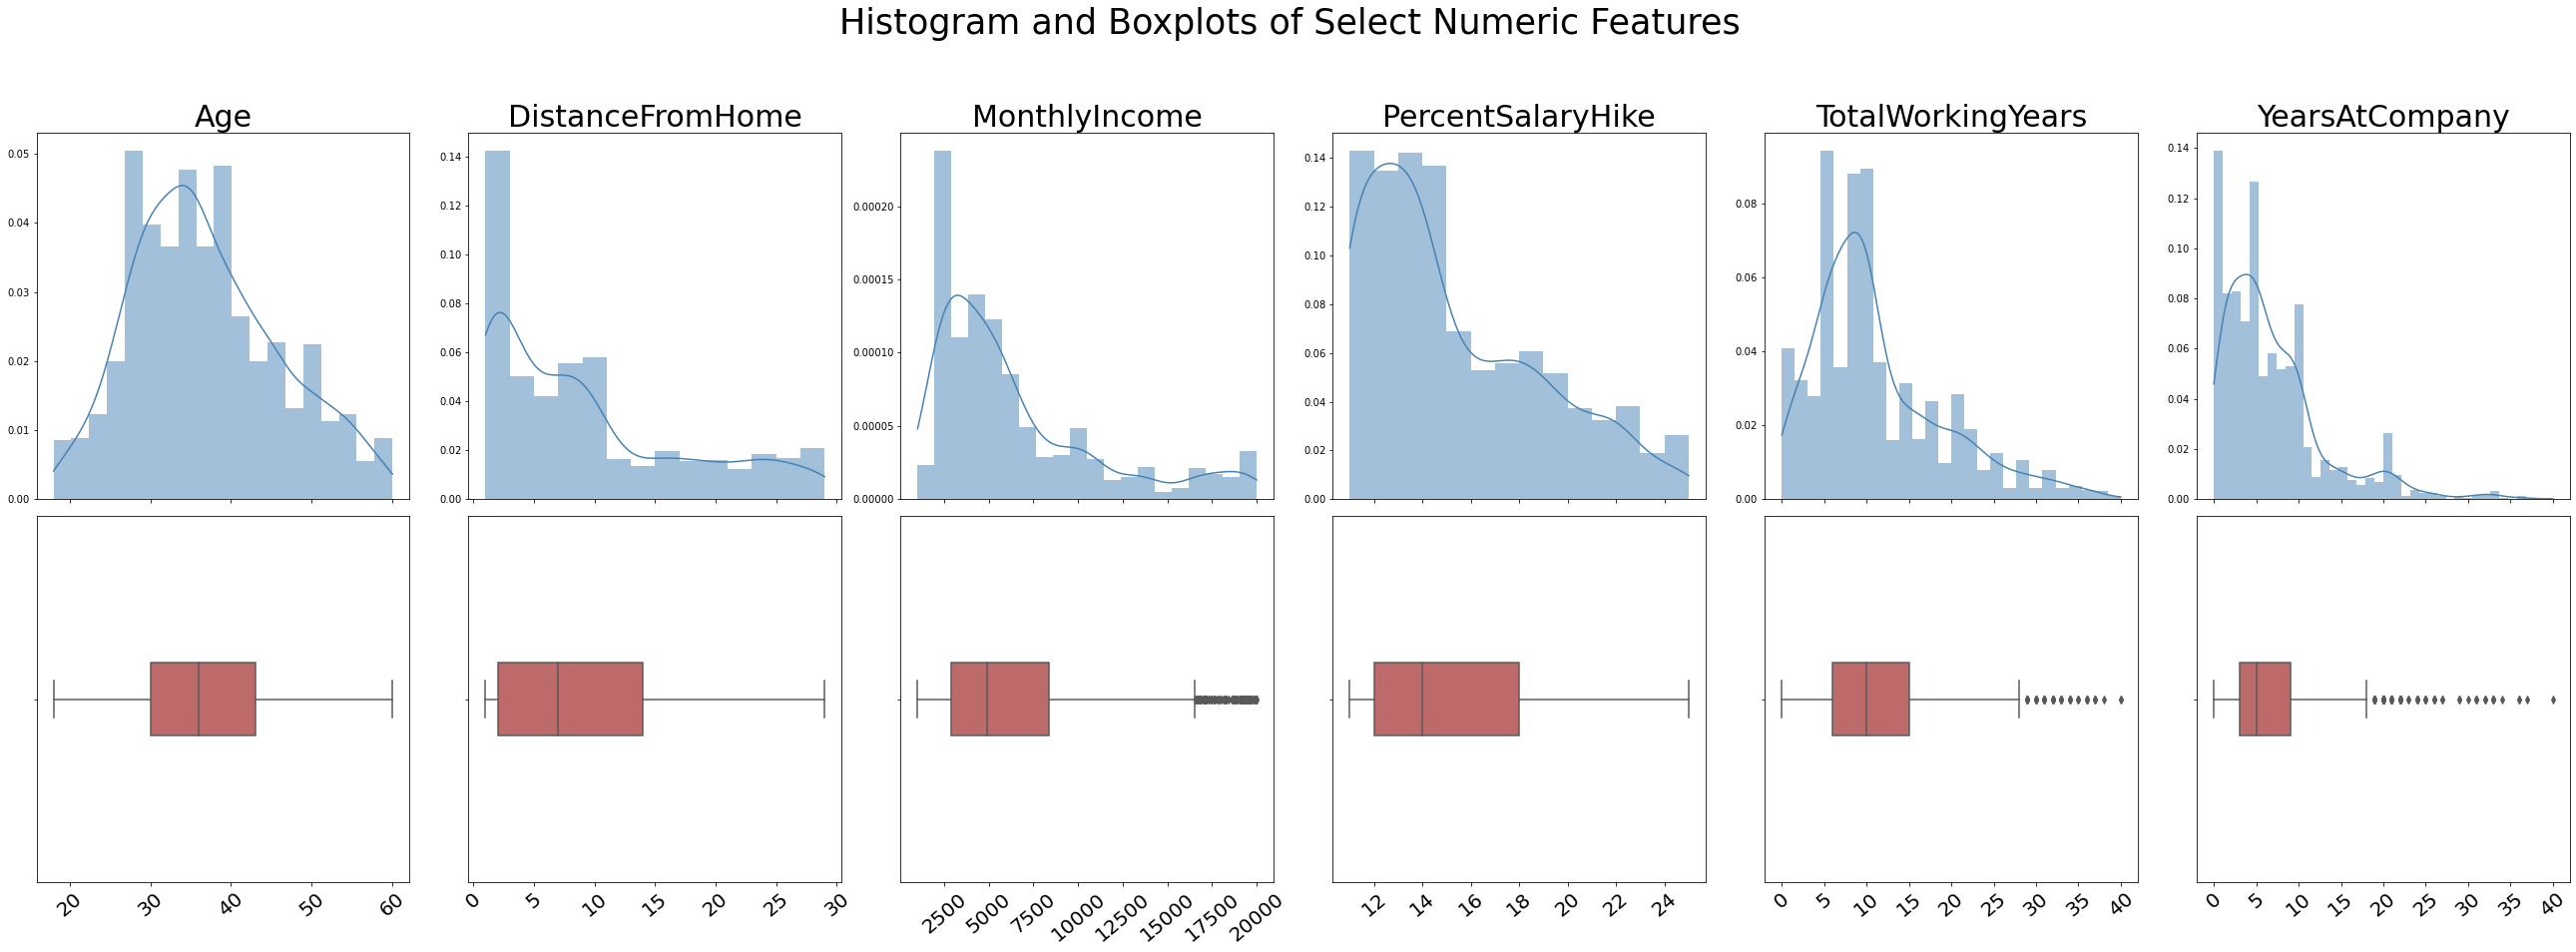

In [186]:
# Visualization of Summary Statistics of Select Numeric Variables

select_floatvars = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'PercentSalaryHike', 'TotalWorkingYears', 'YearsAtCompany']

plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
fig, ax = plt.subplots(2, len(select_floatvars), figsize = (6*len(select_floatvars), 6*2))
for i, item in enumerate(select_floatvars):

    # Plot the histogram first with kernel density estimates
    plt.subplot(2, len(select_floatvars), i+1)
    g = sns.histplot(IBMData, x = select_floatvars[i], stat = 'density', color = 'steelblue', kde = True)
    g.set_title(select_floatvars[i], fontsize = 30)
    g.set_ylabel('')
    g.set_xlabel('')
    g.set_xticklabels([])
    
    # Then plot the boxplot with median values
    plt.subplot(2, len(select_floatvars), i+7)
    f = sns.boxplot(IBMData[item], color = 'indianred', width = 0.2, orient = 'v')  
    plt.draw()
    labels = [newitem.get_text() for newitem in f.get_xticklabels()]
    f.set_xlabel('')    
    f.set_xticklabels(labels, fontsize = 20, rotation = 40)
plt.tight_layout()    
plt.suptitle('Histogram and Boxplots of Select Numeric Features', fontsize = 35, y = 1.1)
plt.show()

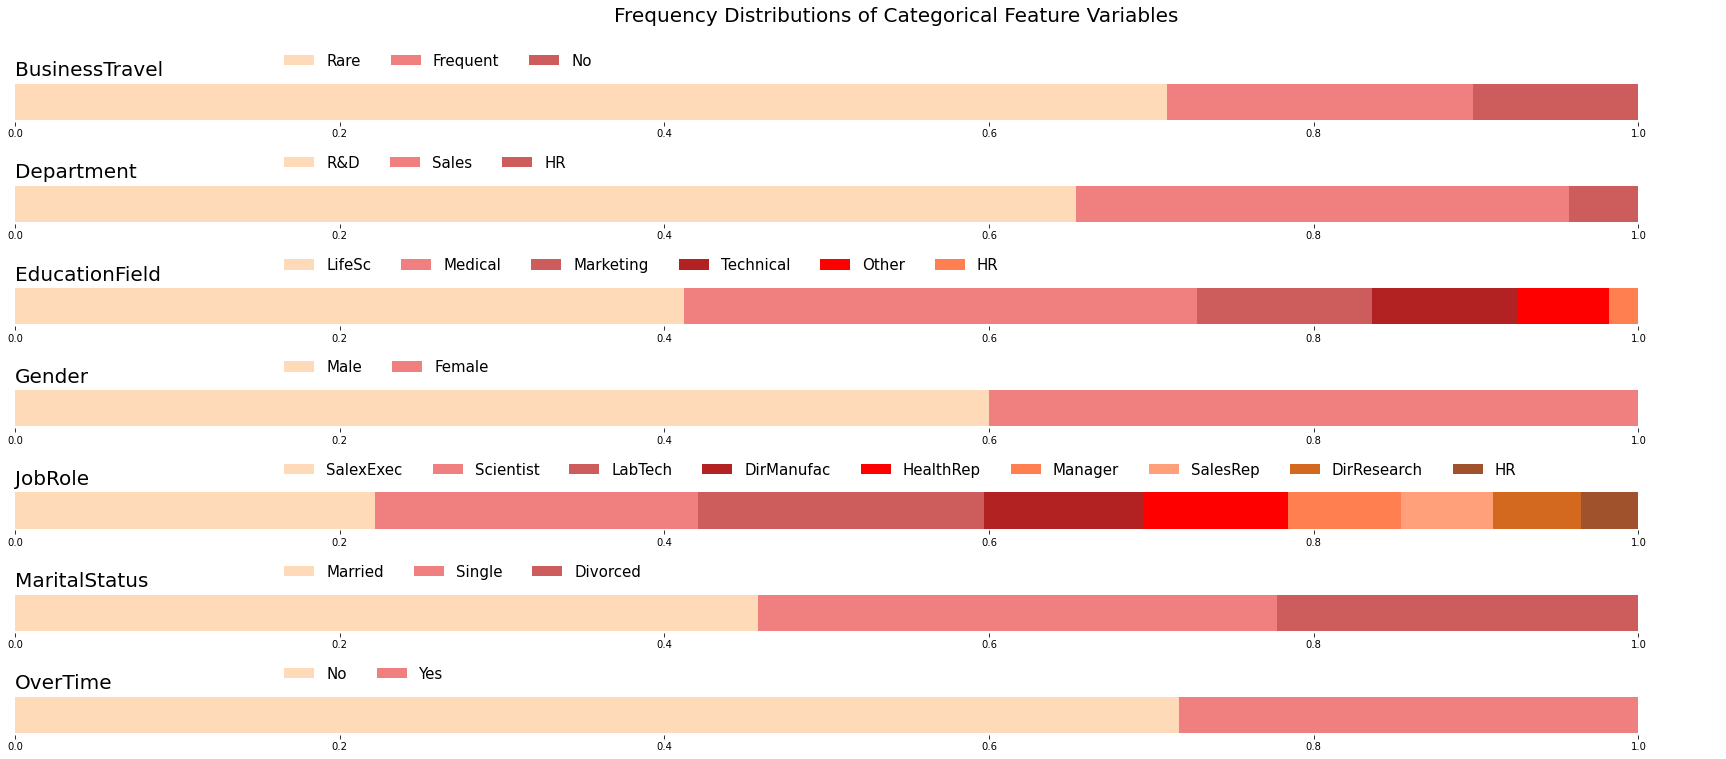

In [206]:
## Frequency Distributions of Select Categorical Variables

# Define a function which takes in the variable and then plots a frequency bar
def plot_catfreq(data, varname, axes, colors):
    
    # First create a dataframe which contains the frequency of the levels in the column defined by varname 
    df_grouped = pd.DataFrame(data[varname].value_counts()/len(data)).transpose()
    fields = df_grouped.columns.to_list()
    left = len(df_grouped)*[0]
    for idx, name in enumerate(fields):
        axes.barh(df_grouped.index, df_grouped[name], left = left, color = colors[idx], height = 0.5)
        left = left + df_grouped[name]
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.spines['bottom'].set_visible(False)    
    axes.set_title(varname, loc = 'left', fontsize = 20)
    axes.legend(fields, ncol = data[varname].nunique(), frameon = False, bbox_to_anchor = ([0.15, 1.0, 0., 0.]), fontsize = 15)     
    axes.set_yticks([])  
    xticks = np.arange(0,1.1,0.1)
    xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
    
# Now define the parameters to pass to the function
colors = ['peachpuff', 'lightcoral','indianred','firebrick','red','coral','lightsalmon','chocolate','sienna','maroon']
fig, ax = plt.subplots(nrows = len(catvars), ncols = 1, figsize = (25, 1.5*len(catvars)))
for i, axes in enumerate(ax.flatten()):
    plot_catfreq(IBMData, catvars[i], axes, colors)
plt.suptitle('Frequency Distributions of Categorical Feature Variables', fontsize = 20, y = 1.0)    
plt.tight_layout()
plt.show()   

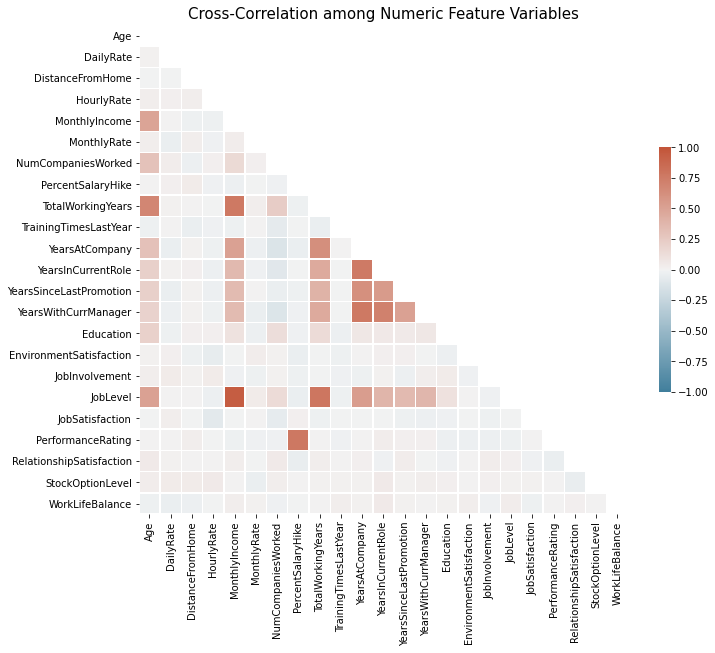

In [217]:
# Cross Correlations of Numeric Variables 

# First compute the correlation matrix
corr = IBMData[numvars + ordvars].corr()
# Mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype = bool))
fig, ax = plt.subplots(figsize = (11,9))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
g = sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1.0, vmin = -1.0, center = 0, square = True, linewidth = 0.5, cbar_kws={"shrink": .5})
g.set_title('Cross-Correlation among Numeric Feature Variables', fontsize = 15);